# Pachete necesare pentru folosirea acestui Notebook

Vom folosi [scipy](https://scipy.org/), [numpy](https://numpy.org/) și [matplotlib](https://matplotlib.org/).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import misc, ndimage, datasets
from scipy.fft import dctn, idctn
import math

# Imaginea cu care lucrăm

Vom folosi o imagine din setul de date oferit implicit de către scipy.

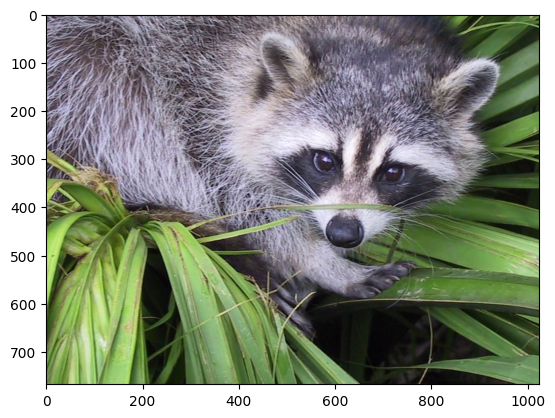

In [2]:
X = datasets.face()
plt.imshow(X)
plt.show()

<h3>Conversia RGB - YCbCr</h3> 

In [59]:
def rgb2ycbcr(img : np.array) -> np.array:
    cmatrix = np.array([[.299, .587, .114], [-.1687, -.3313, .5], [.5, -.4187, -.0813]])
    ycbcr = []

    for line in img:
        p_line = []
        for pixel in line:
            newp = np.dot(pixel, cmatrix.T)
            newp[1] += 128
            newp[2] += 128
            #for i in range(len(newp)):
            #    newp[i] = math.floor(newp[i])

            #newp = newp.astype('int32')
            p_line.append(newp)
        
        ycbcr.append(p_line)

    return np.array(ycbcr)



# Transformata DCT a unei imagini

Transformata DCT se extinde la mai multe dimensiuni similar cu transformata DFT. Pentru un semnal bidimensional, precum o imagine, DCT-II devine:

$$
Y_{m_1,m_2} = \sum_{n_1=0}^{N_1-1}
              \sum_{n_2=0}^{N_2-1}
              x_{n_1,n_2}
              \cos\left[\frac{\pi}{N_1}m_1
                \left(n_1 + \frac12\right)\right]
              \cos\left[\frac{\pi}{N_2}m_2\left(n_2 + \frac12\right)\right]
$$

* unde $n_1$ și $n_2$ sunt pozițile pixelilor pe orizontală, respectiv, pe verticală
* bin-urile rezultate corespund pozițiilor pixelilor
* spectrul este în continuare simetric și par
* proprietățile transformatei DCT-II sunt respectate și în cazul celei 2D

În Python avem rutina `scipy.fft.dct` pentru 1D și `scipy.fft.dctn` pentru generalizarea la semnale $n$-dimensionale. Dimensiunea este determinată automat după forma semnalului; tipul DCT poate fi specificat prin atributul `type` (implicit II).

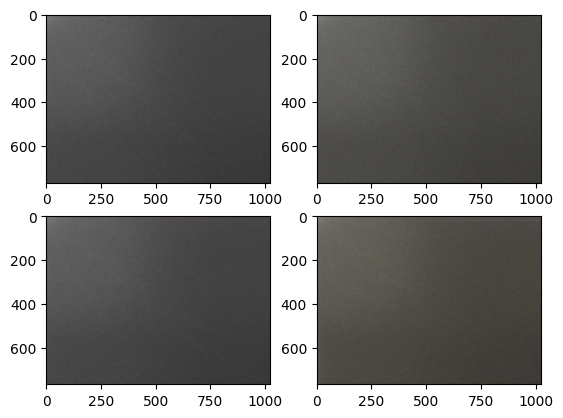

In [4]:
Y1 = dctn(X, type=1)
Y2 = dctn(X, type=2)
Y3 = dctn(X, type=3)
Y4 = dctn(X, type=4)

freq_db_1 = 20*np.log10(abs(Y1))
freq_db_2 = 20*np.log10(abs(Y2))
freq_db_3 = 20*np.log10(abs(Y3))
freq_db_4 = 20*np.log10(abs(Y4))

plt.subplot(221).imshow(freq_db_1.astype(np.uint8))
plt.subplot(222).imshow(freq_db_2.astype(np.uint8))
plt.subplot(223).imshow(freq_db_3.astype(np.uint8))
plt.subplot(224).imshow(freq_db_4.astype(np.uint8))
plt.show()

# Compactarea energiei. Compresie.

Putem profita de proprietatea compresiei energiei prin anularea frecvențelor DCT începând cu *bin*-ul `k` după care aplicăm transformata DCT inversă (similar cu tema anterioară):

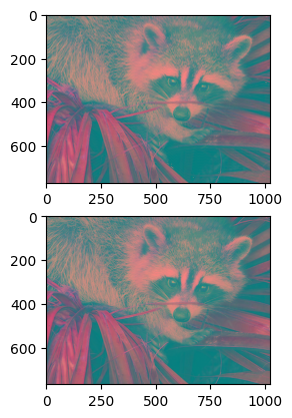

In [11]:
k = 120

Y_ziped = Y2.copy()
Y_ziped[k:] = 0
X_ziped = idctn(Y_ziped)

plt.subplot(211).imshow(X_ziped.astype(np.uint8))
plt.subplot(212).imshow(X.astype(np.uint8))
plt.show()

# JPEG

Algoritmul de compresie JPEG are patru etape:

1. transformarea imaginii din pixeli RGB în Y'CbCr
2. aplicarea 2D-DCT pe blocuri disincte de 8x8 pixeli din imagine
3. cuantizarea în frecvență cu $Q$ dat de standardul JPEG
4. opțional compresia rezultatului cu coduri Huffman

Unde matricea JPEG de cuantizare $Q$ este:
$$
Q =
\begin{bmatrix}
16 & 11 & 10 & 16 & 24 & 40 & 51 & 61 & \\
12 & 12 & 14 & 19 & 26 & 28 & 60 & 55 & \\
14 & 13 & 16 & 24 & 40 & 57 & 69 & 56 & \\
14 & 17 & 22 & 29 & 51 & 87 & 80 & 62 & \\
18 & 22 & 37 & 56 & 68 & 109 & 103 & 77 & \\
24 & 35 & 55 & 64 & 81 & 104 & 113 & 92 & \\
49 & 64 & 78 & 87 & 103 & 121 & 120 & 101\\
72 & 92 & 95 & 98 & 112 & 100 & 103 & 99\\
\end{bmatrix}
$$

Imaginea noastră de test este monocromă, deci nu necesită pasul 1, dar putem efectua o operație de *down-sampling* în preprocesare precum am prezentat la curs.

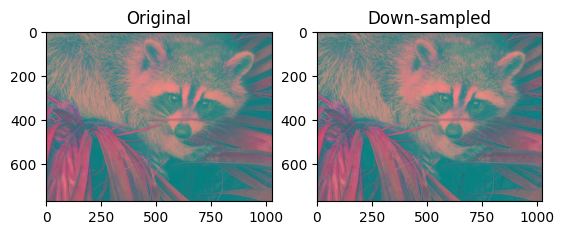

In [60]:
Q_down = 10

X_ds = X.copy()
X_ds = Q_down*np.round(X_ds/Q_down)

plt.subplot(121).imshow(X/255)
plt.title('Original')
plt.subplot(122).imshow(X_ds/255)
plt.title('Down-sampled')
plt.show()

Pentru fiecare bloc de $8\times 8$ aplică DCT și cuantizare.

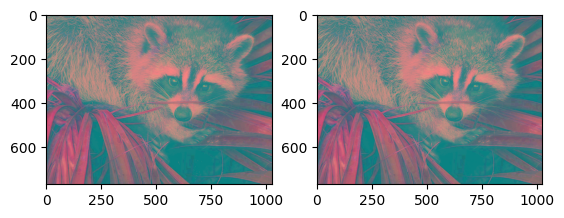

Componente în frecvență:1264018
Componente în frecvență după cuantizare: 705425


In [57]:
Q_jpeg = [[16, 11, 10, 16, 24, 40, 51, 61],
          [12, 12, 14, 19, 26, 28, 60, 55],
          [14, 13, 16, 24, 40, 57, 69, 56],
          [14, 17, 22, 29, 51, 87, 80, 62],
          [18, 22, 37, 56, 68, 109, 103, 77],
          [24, 35, 55, 64, 81, 104, 113, 92],
          [49, 64, 78, 87, 103, 121, 120, 101],
          [72, 92, 95, 98, 112, 100, 103, 99]]

#sub = np.array([[128] * 8] * 8)
X_jpeg = np.zeros(X_ds.shape)

y_nnz = 0
y_jpeg_nnz = 0
k = 120

# Encoding
for i_X in range(8, X.shape[0]+1, 8):
    for i_Y in range(8, X.shape[1]+1, 8):
        # select slice from original image
        x = X_ds[i_X-8:i_X, i_Y-8:i_Y]

        # split into channels and encode
        Y_y = dctn(x[:, :, 0])
        Cb_y = dctn(x[:, :, 1])
        Cr_y = dctn(x[:, :, 2])
    
        Y_y_jpeg = Q_jpeg*np.round(Y_y/Q_jpeg)
        Cb_y_jpeg = Q_jpeg*np.round(Cb_y/Q_jpeg)
        Cr_y_jpeg = Q_jpeg*np.round(Cr_y/Q_jpeg)

    
        Y_y_jpeg[k:] = 0
        Cb_y_jpeg[k:] = 0
        Cr_y_jpeg[k:] = 0
            
        
        # Decoding
        Y_x_jpeg = idctn(Y_y_jpeg)
        Cb_x_jpeg = idctn(Cb_y_jpeg)
        Cr_x_jpeg = idctn(Cr_y_jpeg)
        
        y_nnz += np.count_nonzero(Y_y)
        y_nnz += np.count_nonzero(Cb_y)
        y_nnz += np.count_nonzero(Cr_y)
        
        y_jpeg_nnz += np.count_nonzero(Y_y_jpeg)
        y_jpeg_nnz += np.count_nonzero(Cb_y_jpeg)
        y_jpeg_nnz += np.count_nonzero(Cr_y_jpeg)

        x_jpeg = np.stack([Y_x_jpeg, Cb_x_jpeg, Cr_x_jpeg], axis=2)
        # Insert into matrix

        for ni_X in range(i_X-8, i_X):
            for ni_Y in range(i_Y-8, i_Y):
                X_jpeg[ni_X, ni_Y] = x_jpeg[ni_X % 8, ni_Y % 8]


plt.subplot(121).imshow(X_jpeg.astype(np.uint8))
plt.subplot(122).imshow(X_ds.astype(np.uint8))
plt.show()

print('Componente în frecvență:' + str(y_nnz) + 
      '\nComponente în frecvență după cuantizare: ' + str(y_jpeg_nnz))



In [63]:
def JPEGCompress(image):
    # Convert color space
    X = rgb2ycbcr(image)

    # Downsample
    Q_down = 10

    X_ds = X.copy()
    X_ds = Q_down*np.round(X_ds/Q_down)

    Q_jpeg = [[16, 11, 10, 16, 24, 40, 51, 61],
          [12, 12, 14, 19, 26, 28, 60, 55],
          [14, 13, 16, 24, 40, 57, 69, 56],
          [14, 17, 22, 29, 51, 87, 80, 62],
          [18, 22, 37, 56, 68, 109, 103, 77],
          [24, 35, 55, 64, 81, 104, 113, 92],
          [49, 64, 78, 87, 103, 121, 120, 101],
          [72, 92, 95, 98, 112, 100, 103, 99]]

    #sub = np.array([[128] * 8] * 8)
    X_jpeg = np.zeros(X_ds.shape)

    y_nnz = 0
    y_jpeg_nnz = 0
    k = 120

    # Encoding
    for i_X in range(8, X.shape[0]+1, 8):
        for i_Y in range(8, X.shape[1]+1, 8):
            # select slice from original image
            x = X_ds[i_X-8:i_X, i_Y-8:i_Y]

            # split into channels and encode
            Y_y = dctn(x[:, :, 0])
            Cb_y = dctn(x[:, :, 1])
            Cr_y = dctn(x[:, :, 2])
    
            Y_y_jpeg = Q_jpeg*np.round(Y_y/Q_jpeg)
            Cb_y_jpeg = Q_jpeg*np.round(Cb_y/Q_jpeg)
            Cr_y_jpeg = Q_jpeg*np.round(Cr_y/Q_jpeg)

    
            Y_y_jpeg[k:] = 0
            Cb_y_jpeg[k:] = 0
            Cr_y_jpeg[k:] = 0
            
        
            # Decoding
            Y_x_jpeg = idctn(Y_y_jpeg)
            Cb_x_jpeg = idctn(Cb_y_jpeg)
            Cr_x_jpeg = idctn(Cr_y_jpeg)
        
            y_nnz += np.count_nonzero(Y_y)
            y_nnz += np.count_nonzero(Cb_y)
            y_nnz += np.count_nonzero(Cr_y)
        
            y_jpeg_nnz += np.count_nonzero(Y_y_jpeg)
            y_jpeg_nnz += np.count_nonzero(Cb_y_jpeg)
            y_jpeg_nnz += np.count_nonzero(Cr_y_jpeg)

            x_jpeg = np.stack([Y_x_jpeg, Cb_x_jpeg, Cr_x_jpeg], axis=2)
            # Insert into matrix

            for ni_X in range(i_X-8, i_X):
                for ni_Y in range(i_Y-8, i_Y):
                    X_jpeg[ni_X, ni_Y] = x_jpeg[ni_X % 8, ni_Y % 8]


    plt.subplot(121).imshow(X_jpeg.astype(np.uint8))
    plt.subplot(122).imshow(X_ds.astype(np.uint8))
    plt.show()

    print('Componente în frecvență:' + str(y_nnz) + 
      '\nComponente în frecvență după cuantizare: ' + str(y_jpeg_nnz))

    # MSE
    ch_Y = X[:, :, 0] - X_jpeg[:, :, 0]
    ch_Cr = X[:, :, 1] - X_jpeg[:, :, 1]
    ch_Cb = X[:, :, 2] - X_jpeg[:, :, 2]
    sum_Y = np.sum(np.concatenate(np.square(ch_Y)))
    sum_Cr = np.sum(np.concatenate(np.square(ch_Cr)))
    sum_Cb = np.sum(np.concatenate(np.square(ch_Cb)))

    MSE = (sum_Y+sum_Cr+sum_Cb) / (3 * X.shape[0] * X.shape[1])
    print("MSE:", MSE)

    return X_jpeg

MSE: 8.326855764976045


# Sarcini

1. [6p] Completați algoritmul JPEG incluzând toate blocurile din imagine.

2. [4p] Extindeți la imagini color (incluzând transformarea din RGB în Y'CbCr). Exemplificați pe `scipy.misc.face` folosită în tema anterioară.

3. [6p] Extindeți algoritmul pentru compresia imaginii până la un prag MSE impus de utilizator.

4. [4p] Extindeți algoritmul pentru compresie video. Demonstrați pe un clip scurt din care luați fiecare cadru și îl tratați ca pe o imagine.